## Current baseline:

In [1]:
#import sys
#!{sys.executable} -m pip install -r requirements.txt

In [2]:
import matplotlib.pyplot as plt

In [3]:
from problem import get_train_data, get_test_data, WeightedClassificationError

In [4]:
import numpy as np
import tensorflow as tf
from time import time
import pandas as pd
import math

In [5]:
videos_train, labels_train = get_train_data()

In [6]:
len(videos_train)

177

## TOOLS

In [7]:
def plot_slices(num_rows, num_columns, width, height, data):
    
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()



In [8]:
from PIL import Image

def resize_frames(video):
    res=[]
    for frame in video:
        resized_img=Image.fromarray(frame).resize((224,224))
        res.append(np.array(resized_img))
    return np.array(res)

In [9]:
#transforming the data set: each observation now correponds the nth observation
def nth_frame(videolist, n):
    n = 300
    nth_frames=[]
    i=0
    for video in videolist:
        i+=1
        time= video.frame_times[n-1]
        frame= video.read_frame(time)
        nth_frames.append(frame)
    return nth_frames

In [10]:
def create_dataset(startFrame, endFrame, x, y):
    xres= nth_frame(x,startFrame)
    yres= np.array(y)
    for i in range(startFrame+1, endFrame+1):
        temp= nth_frame(x,i)
        xres+= temp
        yres= np.append(yres,np.array(y))
    return xres,yres

In [11]:
builtx, builty= create_dataset(300,300, videos_train, labels_train)

In [12]:
X_for_classifier=np.array(builtx)

In [13]:
X_for_classifier=resize_frames(X_for_classifier)
y_for_classifier= builty

In [14]:
X_for_classifier[None, ...].shape

(1, 177, 224, 224)

In [15]:
#temp fix to make it work with MobileNetV2

grayscale_batch=X_for_classifier
rgb_batch = np.repeat(grayscale_batch[...,np.newaxis], 3, -1)


In [16]:
X_for_classifier= rgb_batch

In [17]:
X_for_classifier.shape

(177, 224, 224, 3)

In [18]:
def class_to_int(argument):
    switcher = {
        'A':0,
        'B':0,
        'C':0,
        'D':0,
        'E':1,
        'F':1,
        'G':1,
        'H':1,
    }
 
    # get() method of dictionary data type returns
    # value of passed argument if it is present
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return switcher.get(argument, "nothing")
 

In [19]:
func=np.vectorize(class_to_int)
y_for_classifier=func(y_for_classifier)

In [20]:
y_for_classifier

array([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0])

## new Baseline test

### predefined pred times:

 ensuring that only frames up to pred_times are used for model training and testing. None is the whole 300 frames.

In [21]:
pred_times = [27, 32, 37, 40, 44, 48, 53, 58, 63, 94, None]

### Build the model

In [22]:
# Image shape for classifier
IMG_SHAPE = (224,224,3)

# Building of a classification model
base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
    )
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation="sigmoid")
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["sparse_categorical_accuracy"],
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

## Data augmentation

In [24]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255, 
        rotation_range=30, fill_mode='nearest',
        width_shift_range=0.1, height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8,1.2] #above 1 light , below darkens
)

In [25]:
XY_classifier_augmented= datagen.flow(X_for_classifier, y_for_classifier, batch_size=32)

In [26]:
model.fit(X_for_classifier,y_for_classifier, epochs=100)

Epoch 1/100
6/6 [==============================] - 4s 68ms/step - loss: 1.1660 - sparse_categorical_accuracy: 0.4068
Epoch 2/100
6/6 [==============================] - 0s 23ms/step - loss: 0.9980 - sparse_categorical_accuracy: 0.4237
Epoch 3/100
6/6 [==============================] - 0s 23ms/step - loss: 0.8564 - sparse_categorical_accuracy: 0.4237
Epoch 4/100
6/6 [==============================] - 0s 23ms/step - loss: 0.8062 - sparse_categorical_accuracy: 0.5480
Epoch 5/100
6/6 [==============================] - 0s 23ms/step - loss: 0.7446 - sparse_categorical_accuracy: 0.5254
Epoch 6/100
6/6 [==============================] - 0s 23ms/step - loss: 0.7493 - sparse_categorical_accuracy: 0.5028
Epoch 7/100
6/6 [==============================] - 0s 23ms/step - loss: 0.7659 - sparse_categorical_accuracy: 0.5706
Epoch 8/100
6/6 [==============================] - 0s 23ms/step - loss: 0.7224 - sparse_categorical_accuracy: 0.5989
Epoch 9/100
6/6 [==============================] - 0s 22ms/step 

6/6 [==============================] - 0s 25ms/step - loss: 0.4238 - sparse_categorical_accuracy: 0.8305
Epoch 71/100
6/6 [==============================] - 0s 27ms/step - loss: 0.4414 - sparse_categorical_accuracy: 0.7853
Epoch 72/100
6/6 [==============================] - 0s 26ms/step - loss: 0.3989 - sparse_categorical_accuracy: 0.8249
Epoch 73/100
6/6 [==============================] - 0s 24ms/step - loss: 0.4068 - sparse_categorical_accuracy: 0.8136
Epoch 74/100
6/6 [==============================] - 0s 22ms/step - loss: 0.4494 - sparse_categorical_accuracy: 0.7853
Epoch 75/100
6/6 [==============================] - 0s 22ms/step - loss: 0.4184 - sparse_categorical_accuracy: 0.8305
Epoch 76/100
6/6 [==============================] - 0s 22ms/step - loss: 0.4431 - sparse_categorical_accuracy: 0.7684
Epoch 77/100
6/6 [==============================] - 0s 24ms/step - loss: 0.4160 - sparse_categorical_accuracy: 0.8079
Epoch 78/100
6/6 [==============================] - 0s 28ms/step - lo

In [27]:
# Uncomment this cell to Load a previously saved model
#MODEL_NAME_FOR_PREDICTION = "classifier3"
#model = tf.keras.models.load_model(os.path.join(MODELS_FOLDER, MODEL_NAME_FOR_PREDICTION))

In [28]:
def predict_image(image, model):
    image = Image.fromarray(image)
    image = image.resize((224,224))
    image = np.array(image)
    image = tf.reshape(image, (1,224,224))
    pred = model.predict(image)
    return np.argmax(pred), np.max(pred)

### Loading test data

In [29]:
videos_test, labels_test  = get_test_data()

In [30]:
builtx, builty= create_dataset(300,300, videos_test, labels_test)

In [31]:
Xtest_for_classifier = resize_frames(builtx)
ytest_for_classifier = np.array(builty)

In [32]:
ytest_for_classifier

array(['A', 'A', 'G', 'A', 'F', 'C', 'H', 'C', 'C', 'H', 'H', 'F', 'H',
       'H', 'E', 'E', 'E', 'C', 'C', 'G', 'H', 'H', 'H', 'E', 'G', 'E',
       'D', 'D', 'G', 'G', 'F', 'G', 'E', 'C', 'E', 'A', 'E', 'E', 'C',
       'G', 'G', 'E', 'A', 'D', 'D', 'D', 'A', 'A', 'F', 'C', 'B', 'F',
       'C', 'B', 'B', 'B', 'C', 'E', 'E', 'B', 'E', 'D', 'G', 'E', 'B',
       'G', 'E', 'D', 'D', 'D', 'A', 'E', 'E', 'C', 'G', 'H', 'H', 'H',
       'F', 'H', 'G', 'B', 'F', 'H', 'H', 'G', 'G', 'E', 'C', 'H', 'A',
       'A', 'H', 'B', 'G', 'G', 'H', 'E', 'D', 'D'], dtype=object)

In [33]:
grayscale_batch=Xtest_for_classifier
rgb_batch = np.repeat(grayscale_batch[..., np.newaxis], 3, -1)

In [34]:
ytest_for_classifier=func(ytest_for_classifier)

In [35]:
ytest_for_classifier

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0])

In [36]:
Xtest_for_classifier= rgb_batch

In [37]:
Xtest_for_classifier.shape

(100, 224, 224, 3)

In [38]:
loss, accuracy = model.evaluate(Xtest_for_classifier, ytest_for_classifier)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 81ms/step - loss: 0.6758 - sparse_categorical_accuracy: 0.6600
Test accuracy : 0.6600000262260437


In [39]:
preds = model.predict(Xtest_for_classifier)
preds = np.argmax(preds, axis=1)
preds

4/4 [==============================] - 1s 22ms/step


array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0], dtype=int64)

In [40]:
ytest_for_classifier

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0])

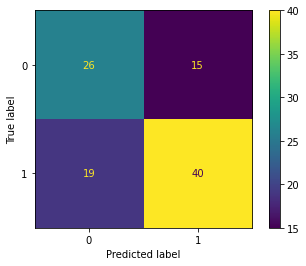

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(ytest_for_classifier, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()
plt.show()

In [42]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']


In [43]:
print(classification_report(ytest_for_classifier, preds,labels=[0,1]))

              precision    recall  f1-score   support

           0       0.58      0.63      0.60        41
           1       0.73      0.68      0.70        59

    accuracy                           0.66       100
   macro avg       0.65      0.66      0.65       100
weighted avg       0.67      0.66      0.66       100

